### Test balancing histograms before rectifying the images

This compares two methods, both calling `skimage.exposure.match_histogram`. (Have not explored other canned or DIY versions).

* Most obvious approach: matched_image = match_histogram( source_image, reference_image )
* Alternative: convert from RGV to HSV, and match V only, then convert back to RGB. This seems to work a little better.

In [1]:
# Test histogram balance
from pathlib import Path
import imageio
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil import tz
import pandas as pd

from skimage import io
# from skimage import data
from skimage import exposure, color
from skimage.exposure import match_histograms
from skimage.color import rgb2hsv, hsv2rgb

from coastcam_funcs import *
from calibration_crs import *
from rectifier_crs import *
from rectify_caco_func import *

['1576598401.jpg', '1594314001.jpg', '1592056801.jpg', '1595527201.jpg', '1589738401.jpg', '1590933601.jpg', '1592319601.jpg', '1584381601.jpg', '1592157601.jpg', '1586977201.jpg']


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


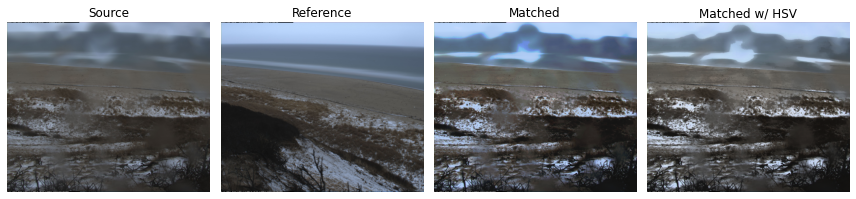

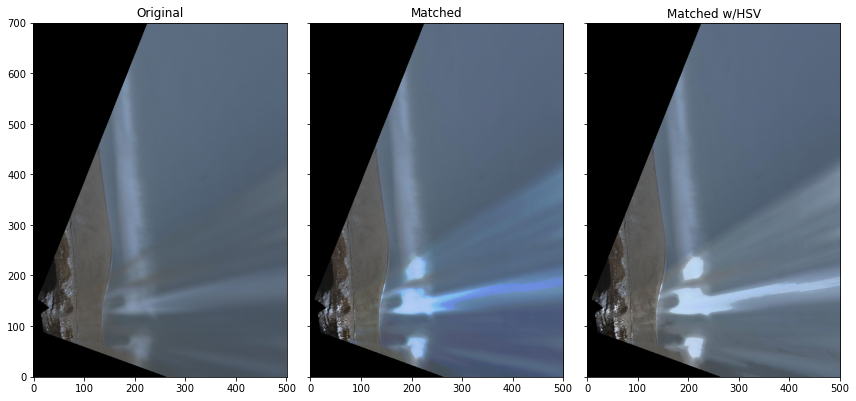

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


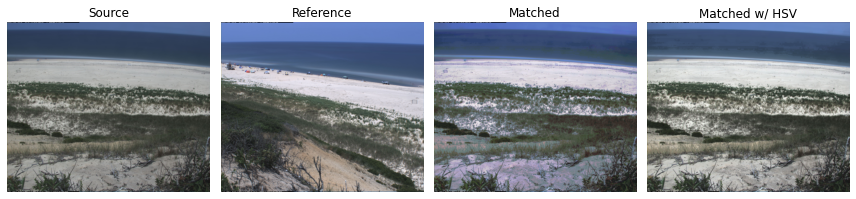

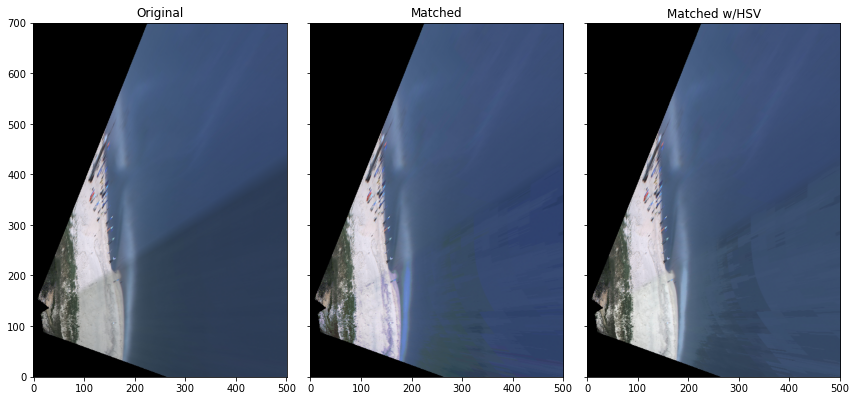

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


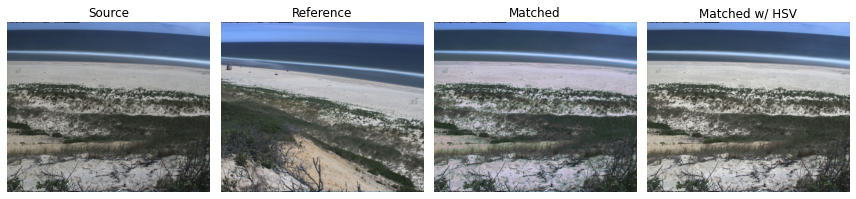

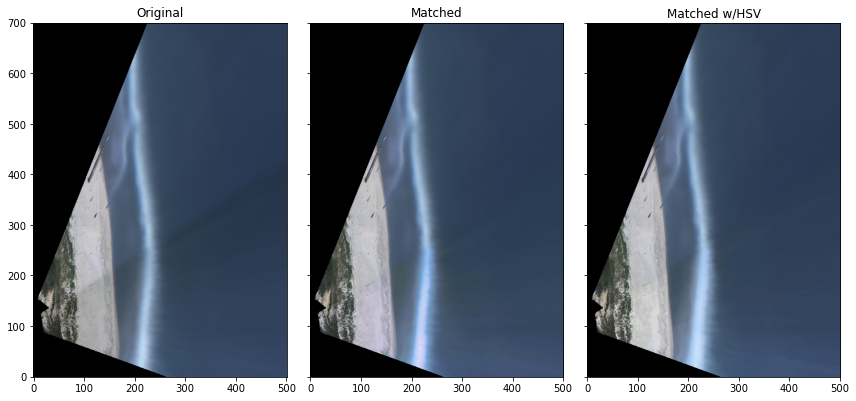

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


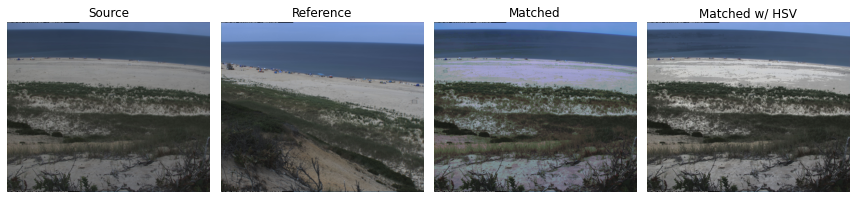

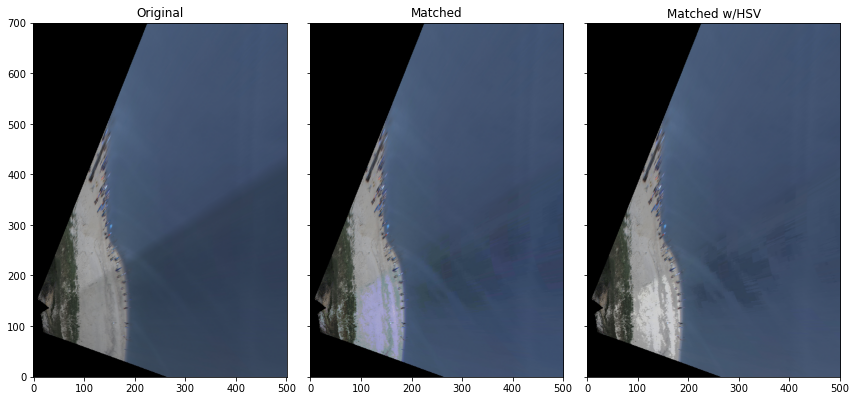

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


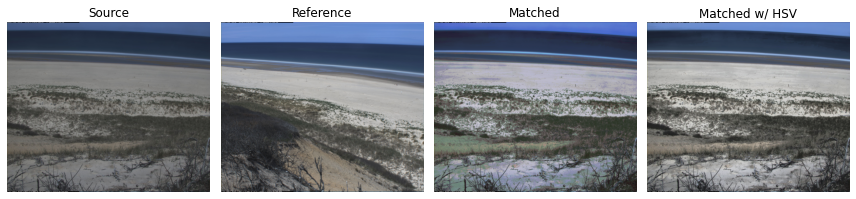

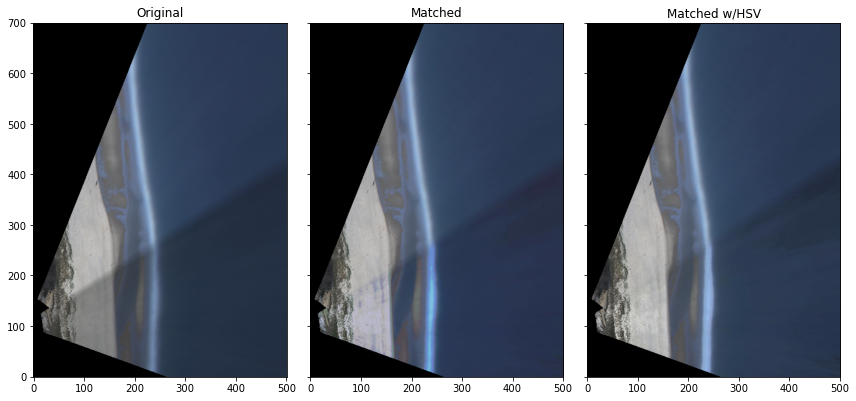

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


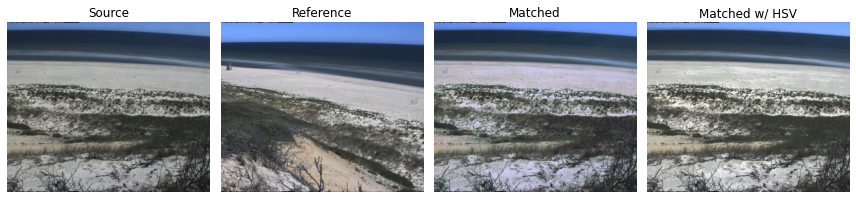

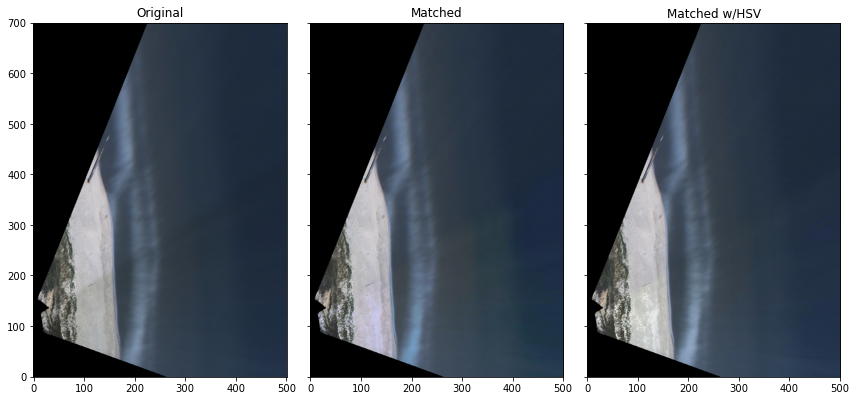

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


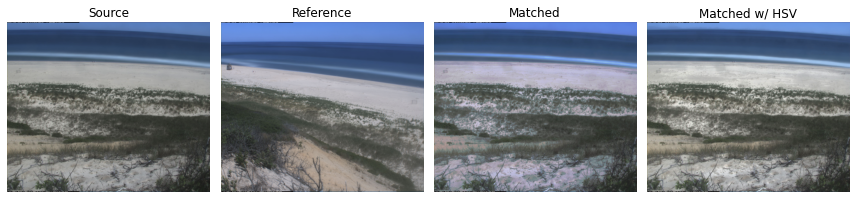

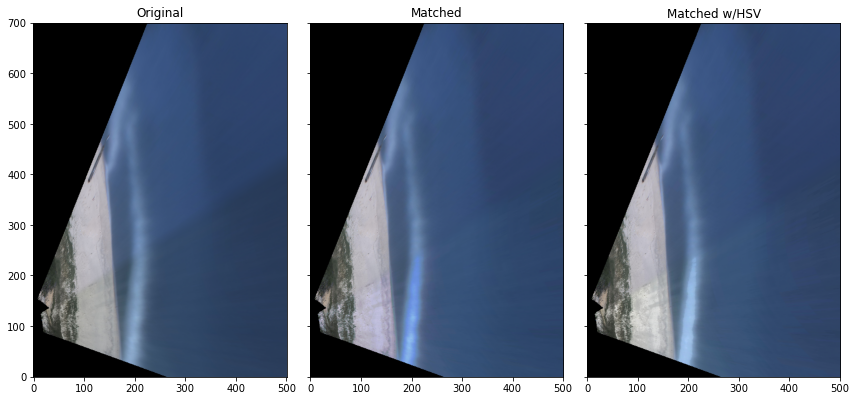

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


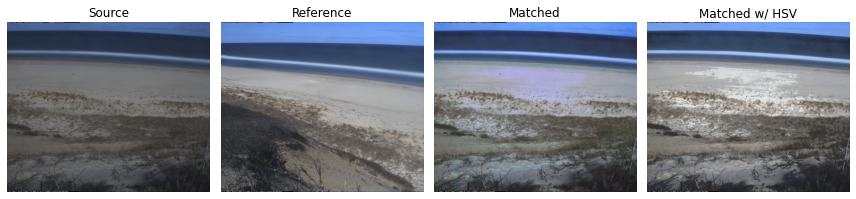

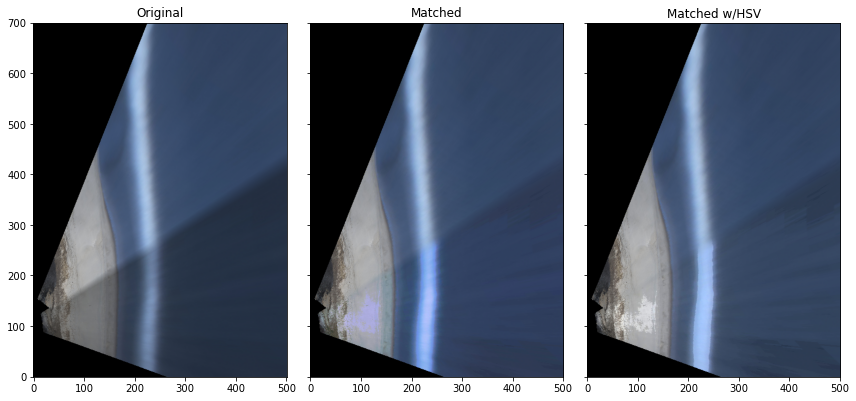

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


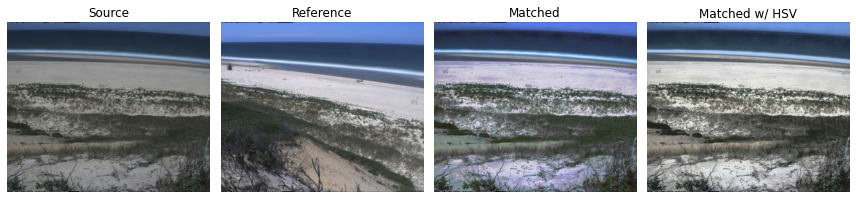

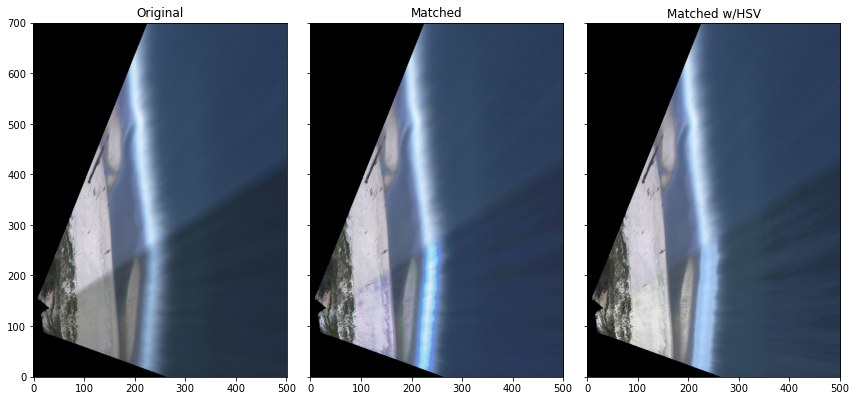

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


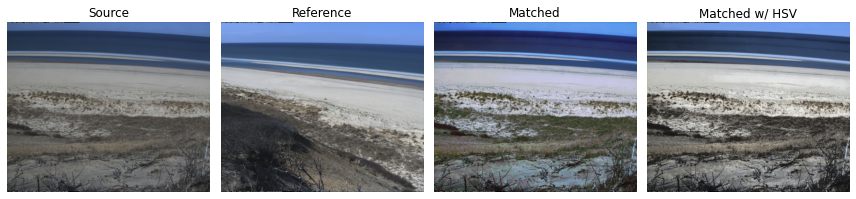

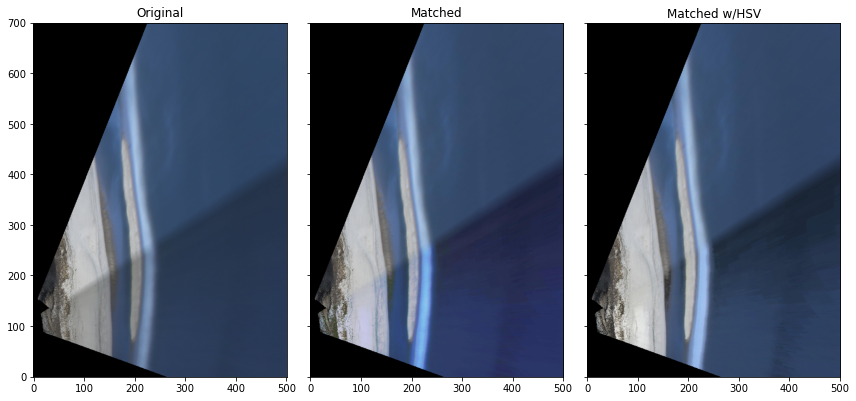

In [2]:
# Read a list of 10 filenames I selected randomly from the S3 products folder
df10=pd.read_pickle('tenfiles.pkl')
flist=df10['filname'].to_list()
print(flist)

# Read the files
# Setup S3 buckets
imdir='cmgp-coastcam/cameras/caco-01/products/'
fs = fsspec.filesystem('s3',profile='coastcam')

# Or use local test files
#files = ['1576260001.c1.timex.jpg','1576260001.c2.timex.jpg']

for i, _ in enumerate(flist):

    fn0 = flist[i].split('.')[0]+'.c1.timex.jpg'
    fn1 = flist[i].split('.')[0]+'.c2.timex.jpg'

    files = [fn0,fn1]

    with fs.open(imdir+files[0],'rb') as f:
        imref = io.imread(f)

    with fs.open(imdir+files[1],'rb') as f:
        imsrc = io.imread(f)
        
    # match RGB histograms    
    matched = match_histograms(imsrc, imref, multichannel=True)

    # try converting to hsv and matching only the last channel (v)
    # convert source and reference from RGB to HSV
    imref_hsv = rgb2hsv(imref)
    imsrc_hsv = rgb2hsv(imsrc)
    # extract the values channel
    imref_v = imref_hsv[:,:,2]
    imsrc_v = imsrc_hsv[:,:,2]
    # match values histogram
    matched_v = match_histograms(imsrc_v,imref_v,multichannel=False)
    # paste matched values channel into HSV version of source image; convert back to RGB
    immatched_hsv = imsrc_hsv.copy()
    immatched_hsv[:,:,2]=matched_v
    matched_rgb = hsv2rgb(immatched_hsv)
    
    # save the images (because the rectification routine uses files, not image arrays)
    with open('c1ref.jpg', 'wb') as f1:
            imageio.imwrite(f1,imref,format='jpg')
    with open('c2matched.jpg', 'wb') as f2:
            imageio.imwrite(f2,matched,format='jpg')
    with open('c2matched_rgb.jpg','wb') as f3:
            imageio.imwrite(f3,matched_rgb,format='jpg')

    # rectify the images
    rimmatch = rectify_caco_func(['c1ref.jpg', 'c2matched.jpg'],fs=None)
    rim = rectify_caco_func([imdir+files[0], imdir+files[1]],fs=fs)
    rimmatchrgb = rectify_caco_func(['c1ref.jpg', 'c2matched_rgb.jpg'],fs=None)

    # make a plot
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 3),
                                        sharex=True, sharey=True)
    for aa in (ax1, ax2, ax3, ax4):
        aa.set_axis_off()
    ax1.imshow(imsrc)
    ax1.set_title('Source')
    ax2.imshow(imref)
    ax2.set_title('Reference')
    ax3.imshow(matched)
    ax3.set_title('Matched')
    ax4.imshow(matched_rgb)
    ax4.set_title('Matched w/ HSV')
    plt.tight_layout()
    plt.show()
    

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 6),
                                        sharex=True, sharey=True)
    ax1.imshow( rim.astype(np.int))
    ax1.invert_yaxis()
    ax1.set_title('Original')
    ax2.imshow( rimmatch.astype(np.int))
    ax2.invert_yaxis()
    ax2.set_title('Matched')
    ax3.imshow( rimmatchrgb.astype(np.int))
    ax3.invert_yaxis()
    ax3.set_title('Matched w/HSV')
    plt.tight_layout()
    plt.show()